In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#assigning path for dataset
data_dir = '/kaggle/input/gtsrb-german-traffic-sign/'
train_path = '/kaggle/input/gtsrb-german-traffic-sign/Train/'
test_path = '/kaggle/input/gtsrb-german-traffic-sign/Test/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [4]:
#finding total classes
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

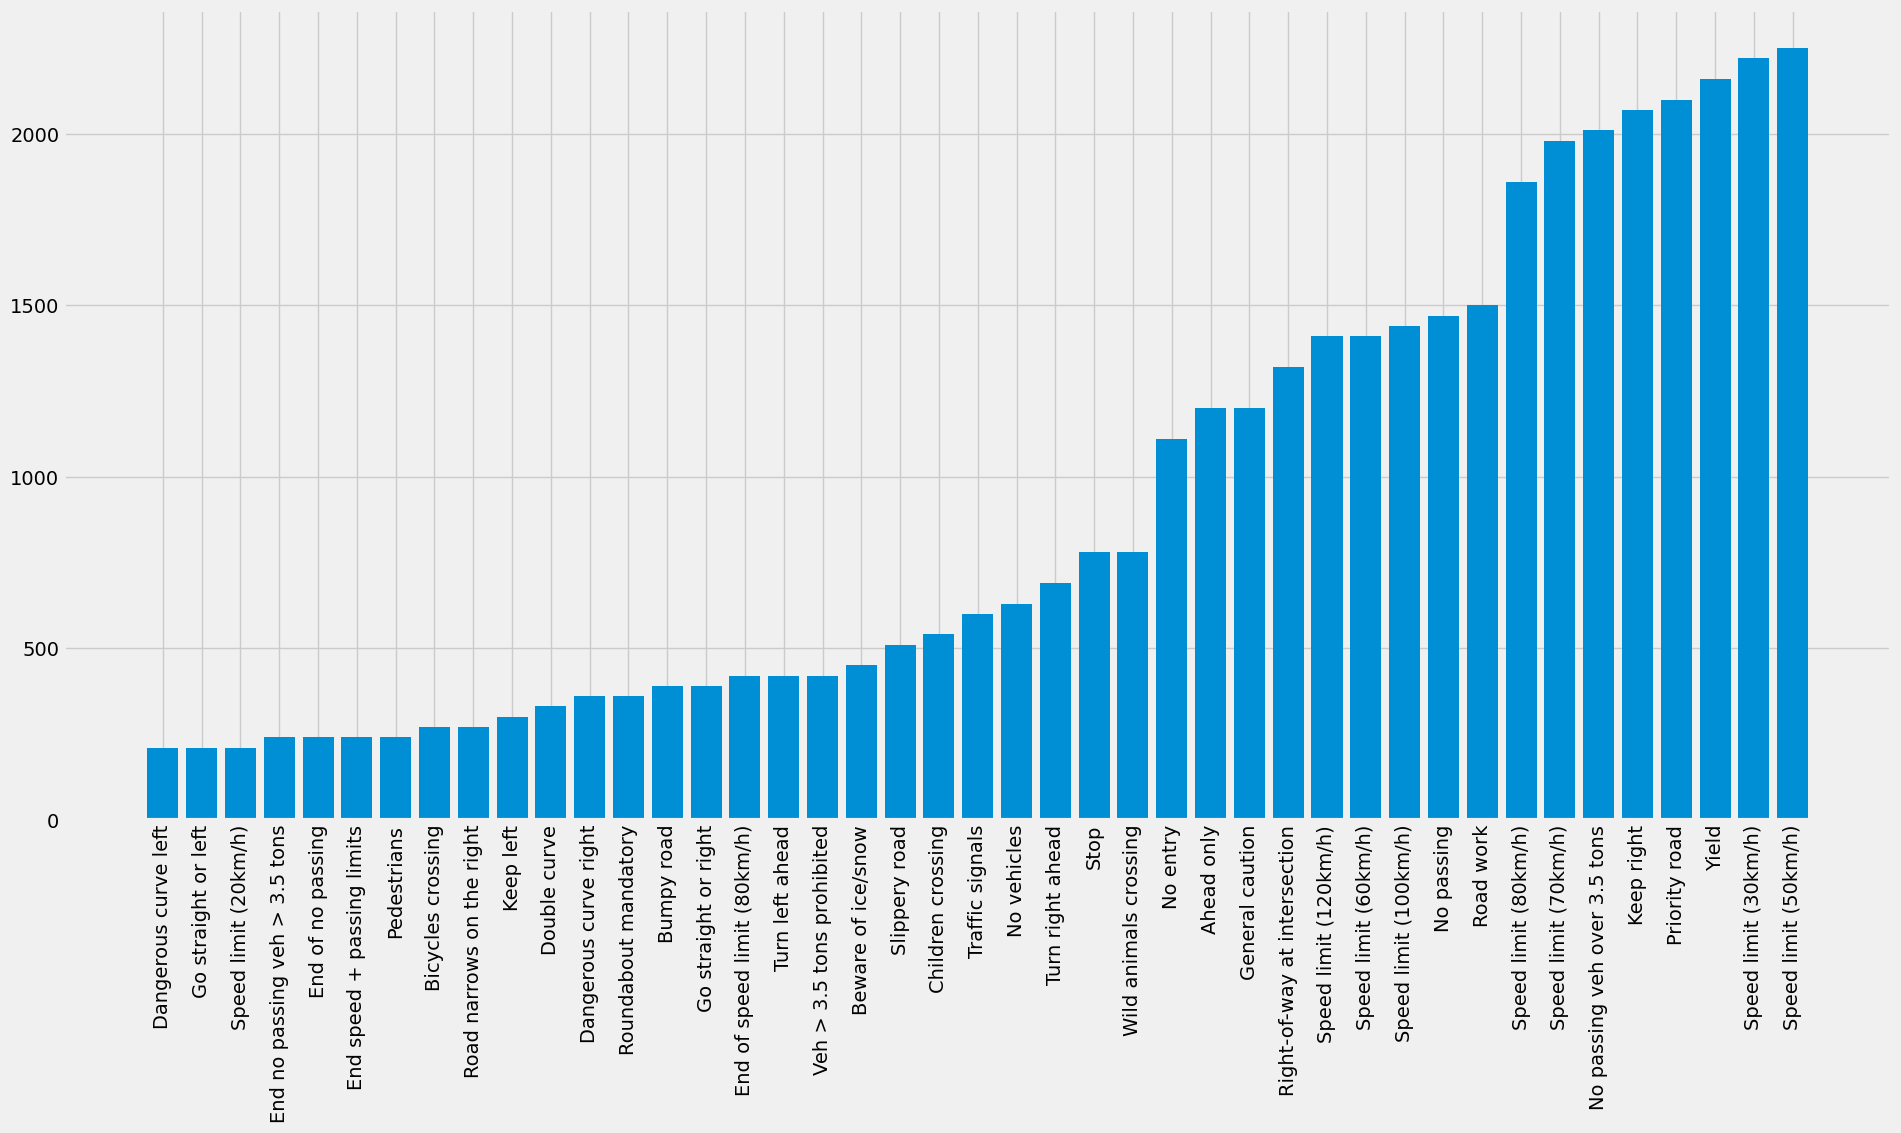

In [6]:
#visualizing the dataset
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

/tmp/ipykernel_34/1256017970.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


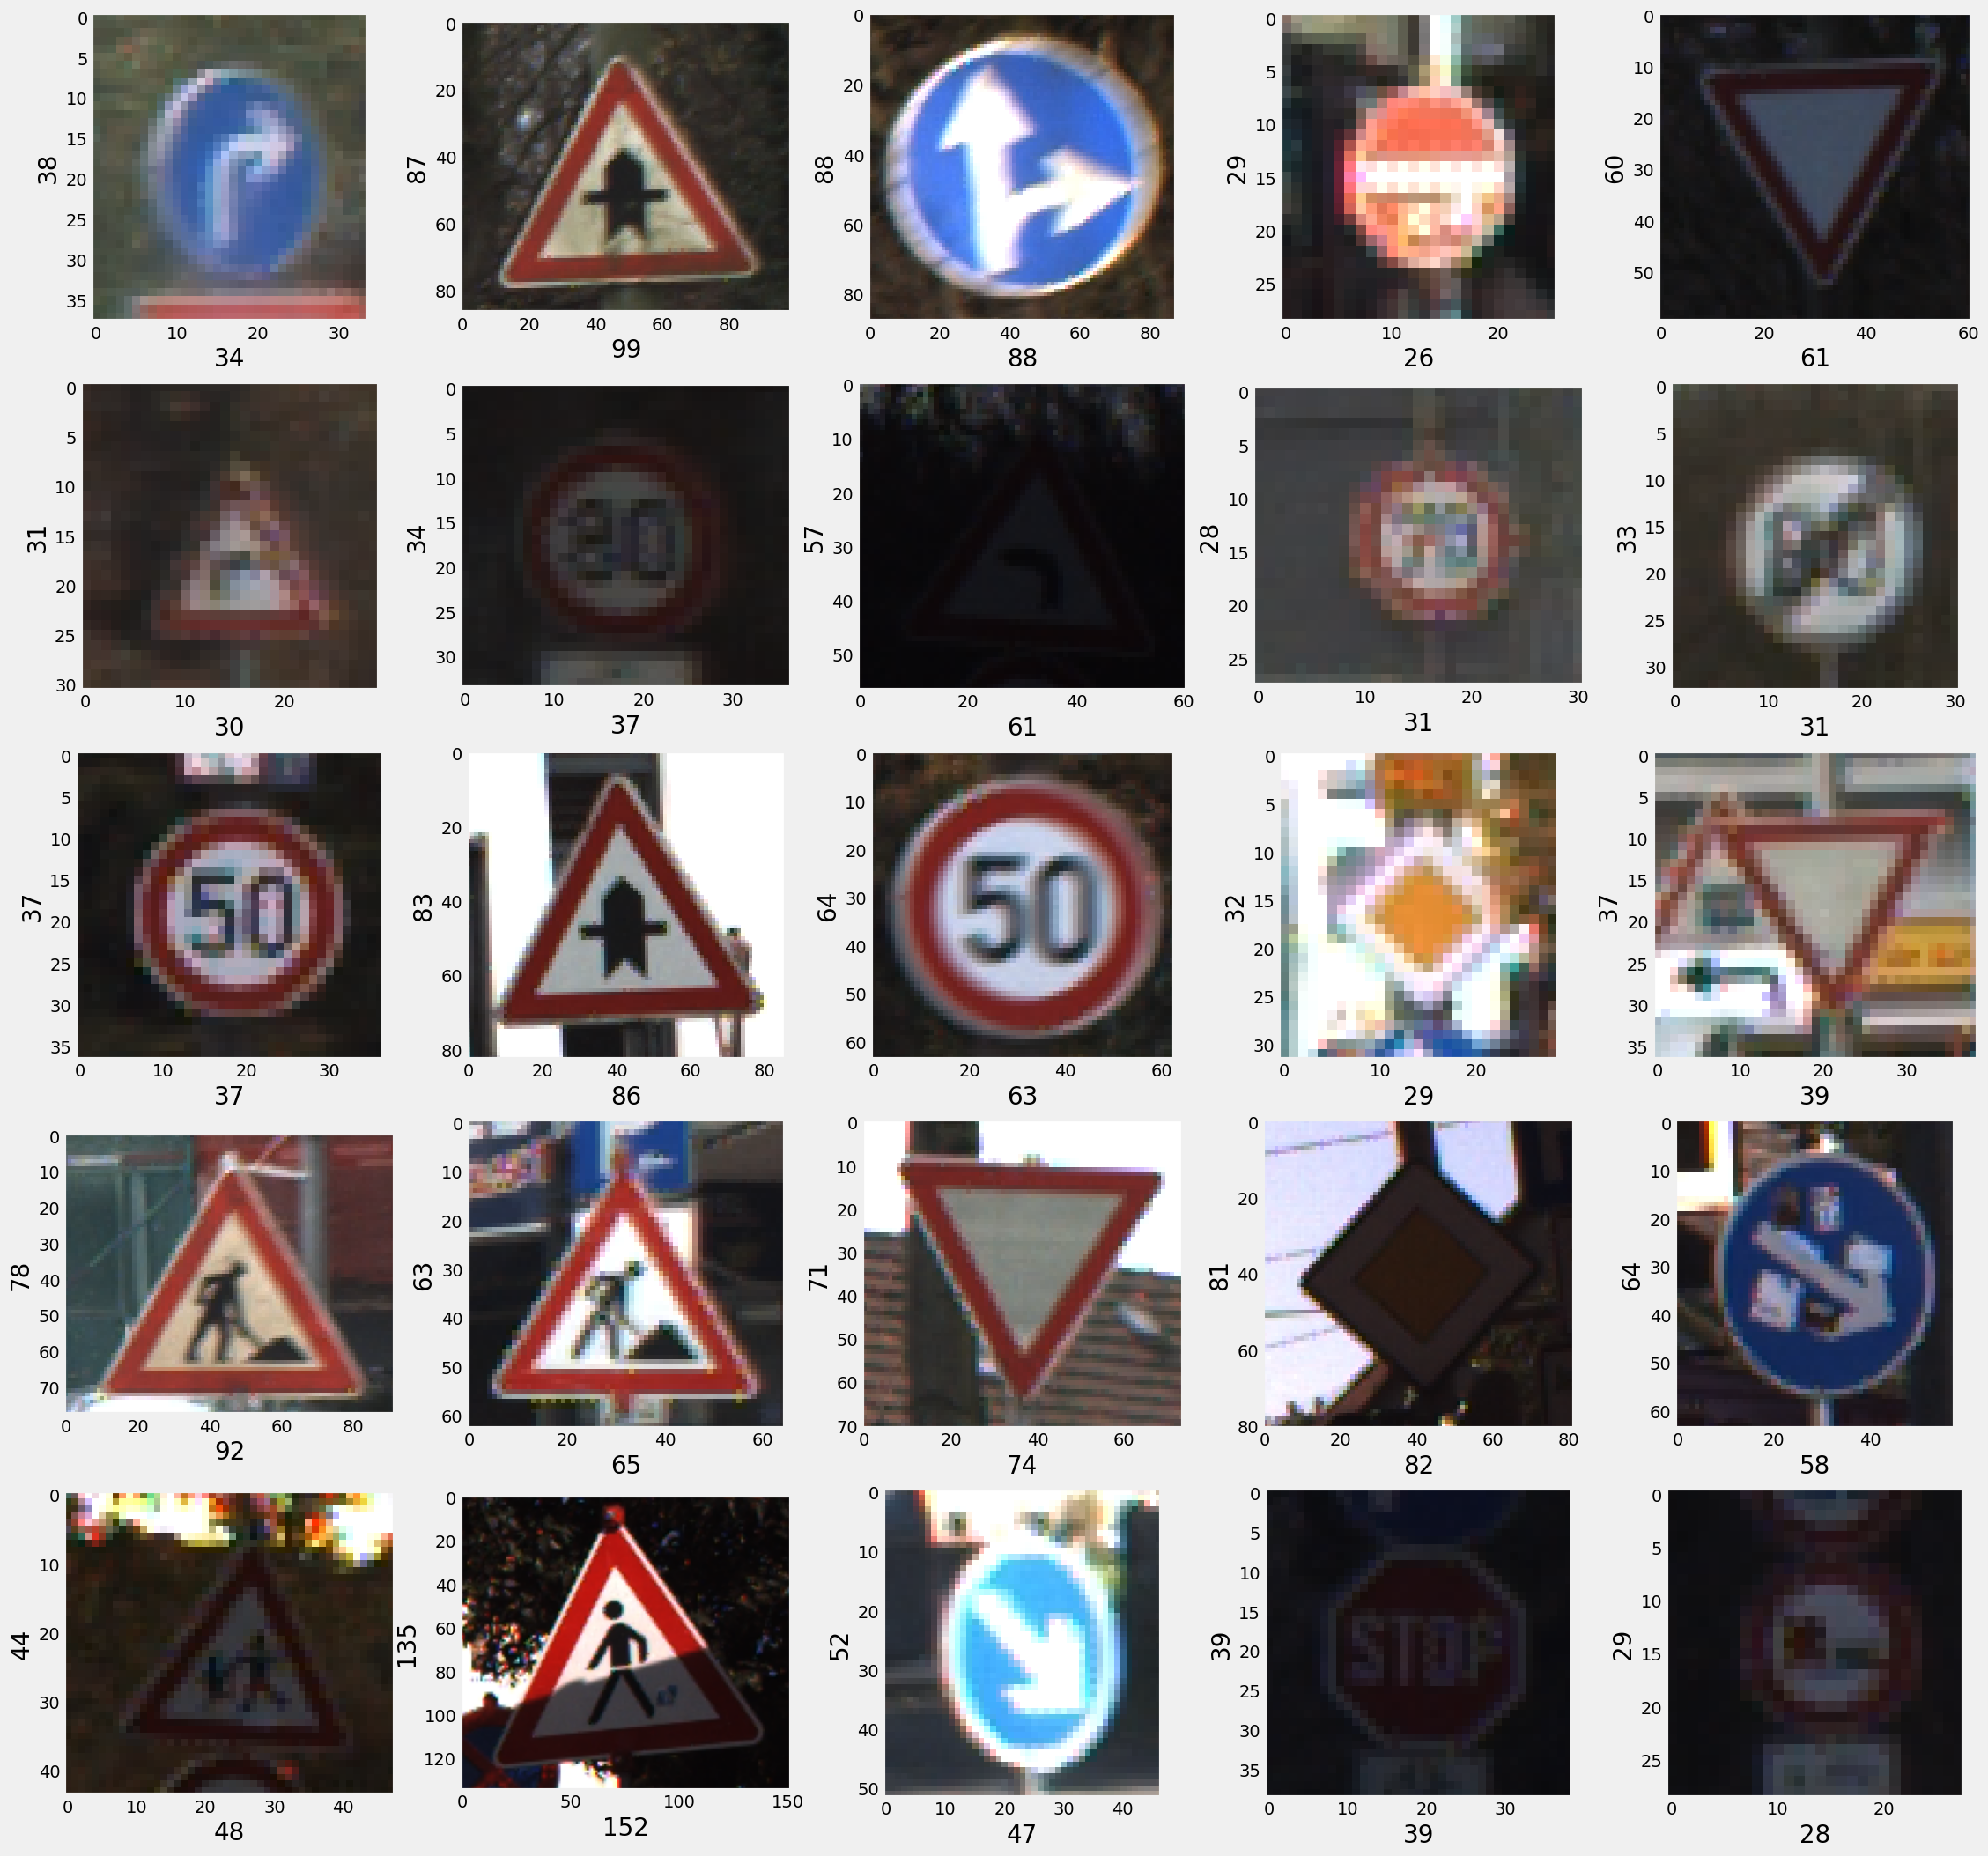

In [7]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [8]:
#Collecting Training data
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [9]:
#Shuffle the training data
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [10]:
#split train and test data
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

# X_train = X_train/255 
# X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [11]:
#one hot encoding of target
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [12]:
#Making model
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [13]:
#epoch
lr = 0.001
epochs = 25

opt = Adam(learning_rate=lr, weight_decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [14]:
#Augumenting the data and training
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/25
858/858 [==============================] - 71s 79ms/step - loss: 1.0383 - accuracy: 0.7177 - val_loss: 0.0909 - val_accuracy: 0.9744
Epoch 2/25
858/858 [==============================] - 65s 76ms/step - loss: 0.1982 - accuracy: 0.9405 - val_loss: 0.0362 - val_accuracy: 0.9917
Epoch 3/25
858/858 [==============================] - 64s 74ms/step - loss: 0.1314 - accuracy: 0.9598 - val_loss: 0.0537 - val_accuracy: 0.9840
Epoch 4/25
858/858 [==============================] - 64s 74ms/step - loss: 0.1074 - accuracy: 0.9671 - val_loss: 0.0465 - val_accuracy: 0.9877
Epoch 5/25
858/858 [==============================] - 64s 75ms/step - loss: 0.0900 - accuracy: 0.9719 - val_loss: 0.0141 - val_accuracy: 0.9958
Epoch 6/25
858/858 [==============================] - 64s 75ms/step - loss: 0.0759 - accuracy: 0.9763 - val_loss: 0.0310 - val_accuracy: 0.9901
Epoch 7/25
858/858 [==============================] - 65s 75ms/step - loss: 0.0702 - accuracy: 0.9778 - val_loss: 0.0649 - val_accuracy:

<function matplotlib.pyplot.show(close=None, block=None)>

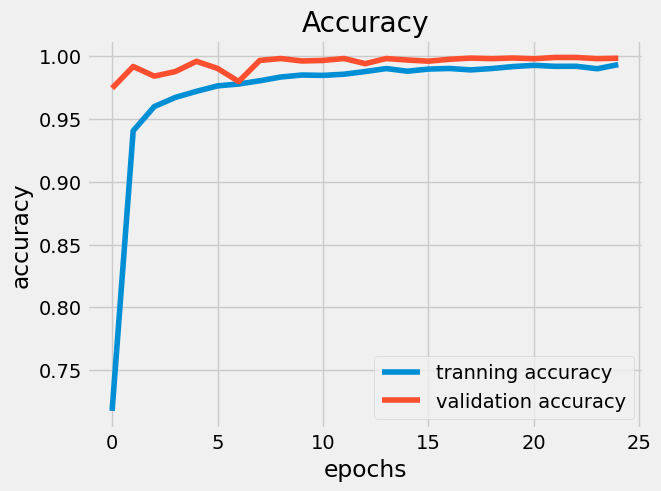

In [15]:
#accuracy
plt.figure(0)
plt.plot(history.history['accuracy'],label='tranning accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

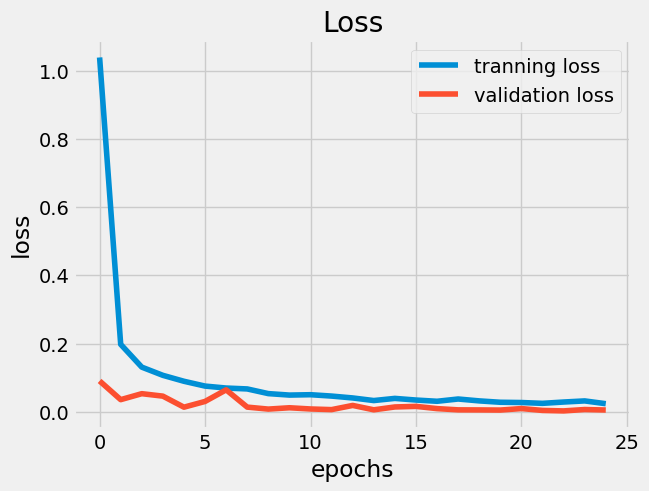

In [16]:
#Loss

plt.plot(history.history['loss'],label='tranning loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show

In [17]:
#loading test data and predictions
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
# X_test = X_test/255


predict_x=model.predict(X_test) 
pred=np.argmax(predict_x,axis=1)



#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 7s 17ms/step
Test Data accuracy:  97.61678543151227


In [18]:
#confusion metrix
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)
cf

array([[ 60,   0,   0, ...,   0,   0,   0],
       [  0, 719,   0, ...,   0,   0,   0],
       [  0,   3, 746, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  88,   0,   0],
       [  0,   0,   0, ...,   0,  54,   0],
       [  0,   0,   0, ...,   0,   8,  81]])

<AxesSubplot: >

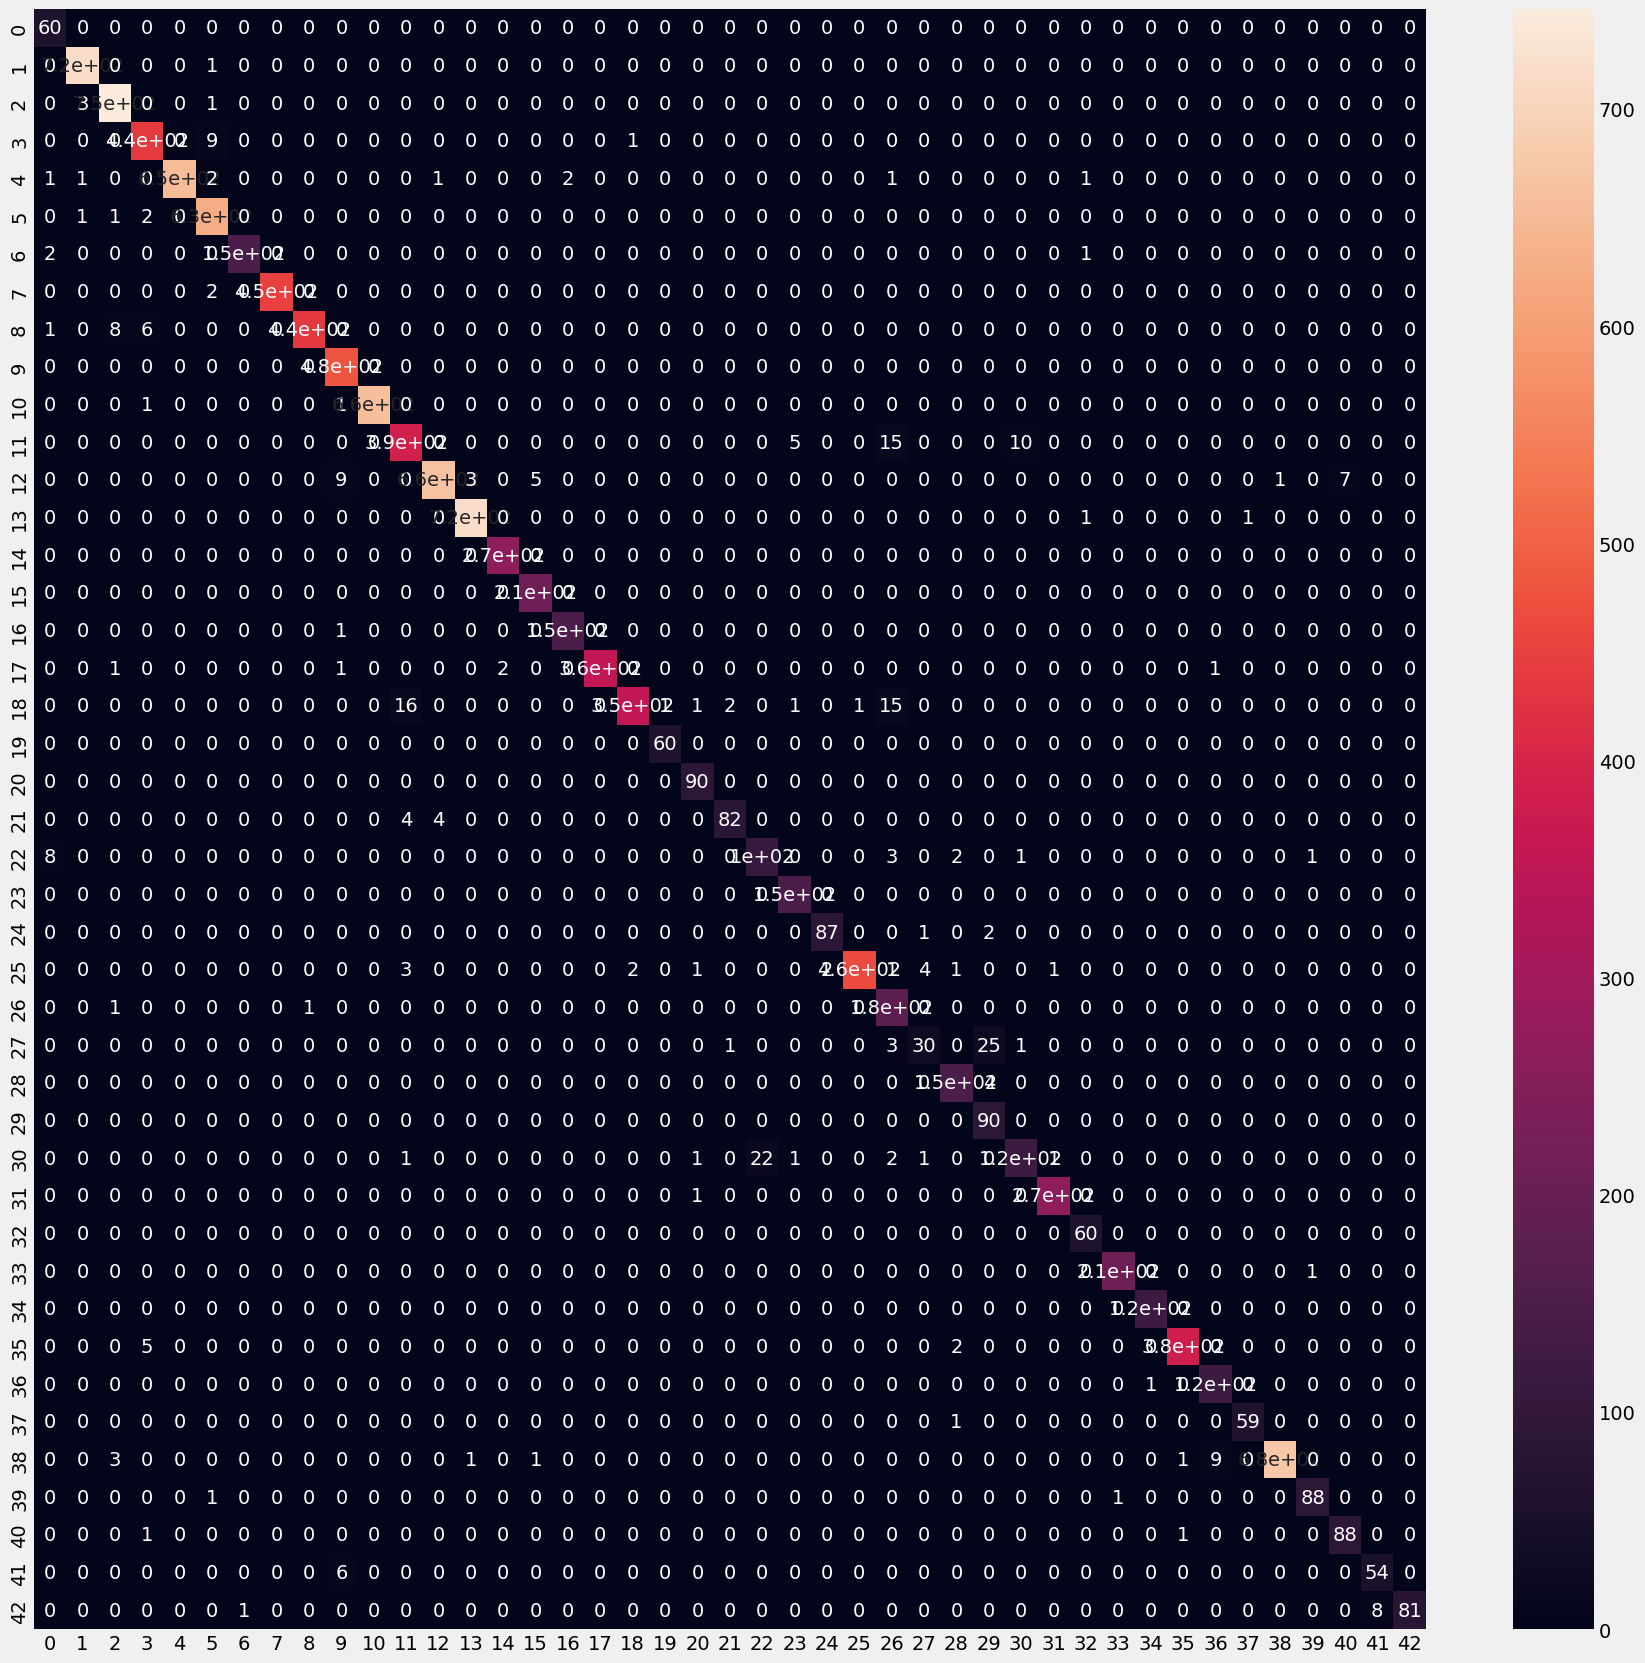

In [19]:
#visualizing confusion metrix
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [20]:
#classification report
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        60
           1       0.99      1.00      1.00       720
           2       0.98      0.99      0.99       750
           3       0.97      0.98      0.97       450
           4       1.00      0.99      0.99       660
           5       0.98      0.99      0.98       630
           6       0.99      0.98      0.99       150
           7       1.00      1.00      1.00       450
           8       1.00      0.97      0.98       450
           9       0.96      1.00      0.98       480
          10       1.00      1.00      1.00       660
          11       0.94      0.93      0.94       420
          12       0.99      0.96      0.98       690
          13       0.99      1.00      1.00       720
          14       0.99      1.00      1.00       270
          15       0.97      1.00      0.99       210
          16       0.99      0.99      0.99       150
          17       1.00    

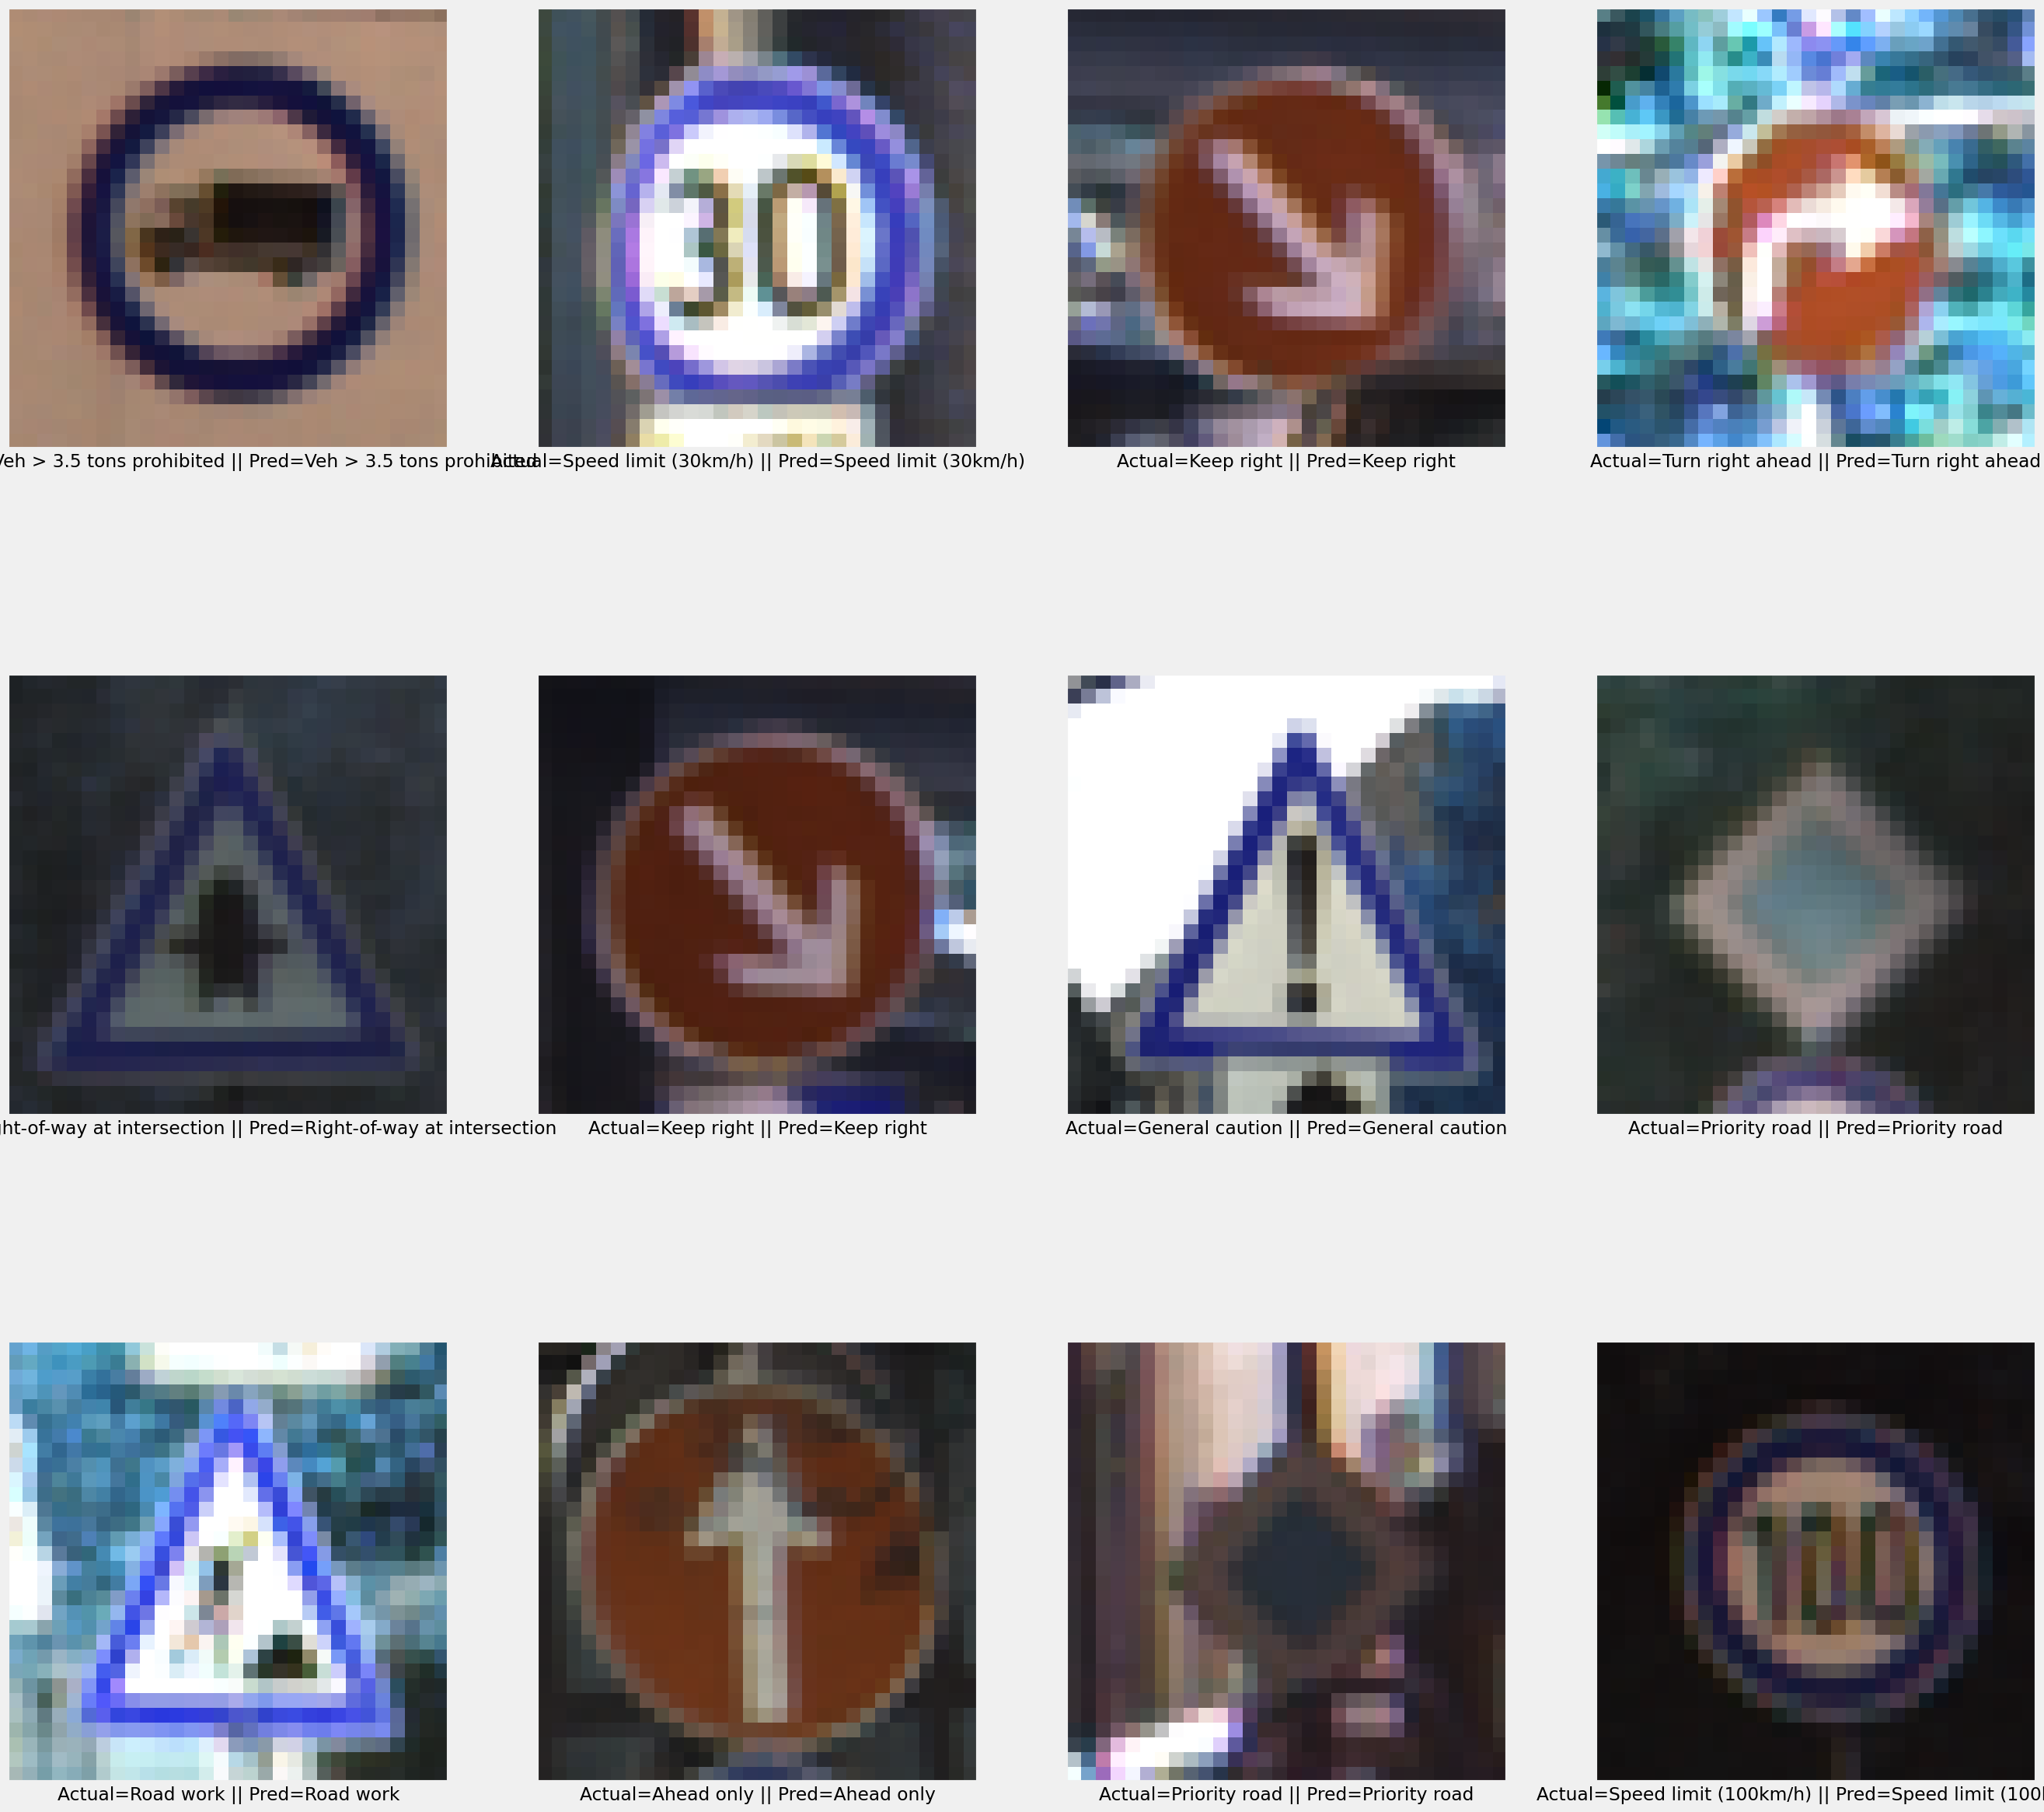

In [21]:
#prediction on test data
plt.figure(figsize = (30, 30))

start_index = 0
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'black'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(classes[actual], classes[prediction]), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [22]:
#prediction 
from PIL import Image

def predict_Image(img):
    data=[]
    image=Image.open(img).resize((30,30))
    data.append(np.array(image))
    X_test = np.array(data)
    
    predict_x=model.predict(X_test) 
    Y_pred=np.argmax(predict_x,axis=1)
    return image,Y_pred

1/1 [==============================] - 0s 29ms/step

Predicted:  Speed limit (60km/h)


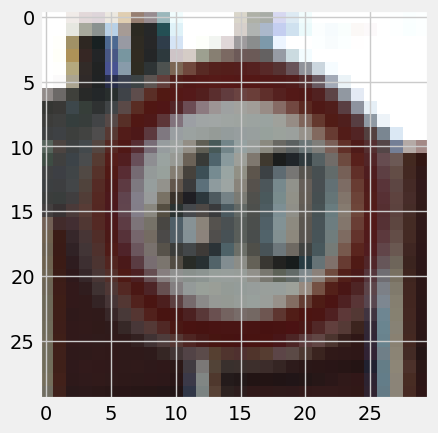

In [23]:
plot,prediction = predict_Image('/kaggle/input/gtsrb-german-traffic-sign/Test/00115.png')
print("\nPredicted: " ,classes[prediction.item()]) #item() converts numpy int64 to native int
plt.imshow(plot)
plt.show()